<a href="https://colab.research.google.com/github/sebasesto/CEIA/blob/master/NLP/Bot_dnn_spacy_esp_Sesto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico N°2
## Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [3]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 6.4 MB 16.5 MB/s 
     |████████████████████████████████| 456 kB 48.4 MB/s 
     |████████████████████████████████| 10.1 MB 39.1 MB/s 
     |████████████████████████████████| 623 kB 23.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 342 kB 35.4 MB/s 


In [42]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout
import stanza
import spacy_stanza
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [43]:
# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2021-09-15 18:20:22 INFO: Downloading default packages for language: es (Spanish)...
2021-09-15 18:20:24 INFO: File exists: /root/stanza_resources/es/default.zip.
2021-09-15 18:20:34 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-09-15 18:20:34 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-09-15 18:20:34 INFO: Use device: cpu
2021-09-15 18:20:34 INFO: Loading: tokenize
2021-09-15 18:20:34 INFO: Loading: mwt
2021-09-15 18:20:34 INFO: Loading: pos
2021-09-15 18:20:35 INFO: Loading: lemma
2021-09-15 18:20:35 INFO: Loading: depparse
2021-09-15 18:20:36 INFO: Loading: ner
2021-09-15 18:20:37 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [44]:
# El preprocesamento en castellano requiere más trabajo
def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [70]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Hola, buenas tardes", "Hola, buenos días", "Buenos días", "Hola! Tengo una consulta" ],
              "responses": ["Hola!", "Hola, ¿Cómo estás?", "Buenas. En que puedo ayudarle."],
             },
             {"tag": "nombre",
              "patterns": ["¿Quienes son?","¿Quién sos?", "¿Con quien me comunico?"],
              "responses": ["Somos grupo Altasur, representantes oficiales de DIAM", "Somos grupo Altasur, proveedores de DIAM en sudamérica",
                            "Somos grupo Altasur y brindamos soluciones enológicas de alta calidad e innovación",]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente número +549261672577", "Contactos al whatsapp +549261672577"]
             },
             {"tag": "asesoramiento",
              "patterns": ["Necesito asesoramiento", "Necesito asesoramiento técnico", "¿Podrían asesorarme con los corchos?",
                           "¿Podrían indicarme el corcho ideal.", "¿Cuál es el mejor corcho para un vino de guarda?", "Necesito información técnica."],
              "responses": ["Por asesoramiento profesional por favor comunicarse por whatsapp al +549261672577", "Para asesorarte necesitaría que envíes un whatsapp al +549261672577"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega la mercadería?", "¿Quien se encarrg de la entrega?", "Como entregan?"],
              "responses": ["Tu compra es entregada directamente en la bodega.", "Todos los pedidos son entregado en las instalaciones que tú solicites", "Tenemos diferentes formas de envios según la zona."]
             },
             {"tag": "ubicación",
              "patterns": ["¿Donde los encuentro?", "¿Donde están ubicados?", "¿donde se encuentra la oficina?",
                           "puedo concertar una visita a su planta", "Puedo visitar la fábrica?", "puedo concertar una visita a su planta"],
              "responses": ["Puedes encontrarnos en <dirección>", "Visita nuestra web https://grupoaltasur.com/ para conocer las oficinas más cercanas"]                 
             },
             {"tag": "insumos",
              "patterns":["¿Que insumos ofrecen?","Lista de insumos", "¿Tienen una lista de productos?", "¿Cuales son los productos disponibles?",
                          "Sólo venden corchos?", "¿Que corchos tienen?","¿Que tipos decorchos tienen?"],
              "responses": ["Tenemos 8 tipos distintos de corchos, puedes ver las especificaciones en https://grupoaltasur.com/productos-y-servicios/",
                            "Nuestra gama de productos la podés ver en https://grupoaltasur.com/productos-y-servicios/",
                            "Te invito a ver la sección de productos en https://grupoaltasur.com/productos-y-servicios/"]
             }, 
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["Para brindarte precios deberías consultarnos al +549261672577"]
             },
            {"tag": "stock",
              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock?"],
              "responses": ["Los productos publicados están en stock", "Tenemos stock y se renueva constantemente"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias", "Gracias por tu atención."],
              "responses": ["De nada", "No es nada, ¿necesitas algo más?","Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [71]:
# Datos que necesitaremos, las palabras o vocabilario
words = []  # todas las palabras posibles
classes = [] # tags
doc_X = [] # entradas en tokens
doc_y = [] # salidas en tokens

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X
# El tag de cada intención se almacena como doc_Y (la clase a predecir)
for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [72]:
# Se puede ver como a cada patron de docX se le asignó un tag
for dx, dy in zip(doc_X, doc_y):
  print([dx,dy])

['Hola', 'bienvenida']
['¿Cómo estás?', 'bienvenida']
['¿Qué tal?', 'bienvenida']
['Hola, buenas tardes', 'bienvenida']
['Hola, buenos días', 'bienvenida']
['Buenos días', 'bienvenida']
['Hola! Tengo una consulta', 'bienvenida']
['¿Quienes son?', 'nombre']
['¿Quién sos?', 'nombre']
['¿Con quien me comunico?', 'nombre']
['contacto', 'contacto']
['número de contacto', 'contacto']
['número de teléfono', 'contacto']
['número de whatsapp', 'contacto']
['whatsapp', 'contacto']
['Necesito asesoramiento', 'asesoramiento']
['Necesito asesoramiento técnico', 'asesoramiento']
['¿Podrían asesorarme con los corchos?', 'asesoramiento']
['¿Podrían indicarme el corcho ideal.', 'asesoramiento']
['¿Cuál es el mejor corcho para un vino de guarda?', 'asesoramiento']
['Necesito información técnica.', 'asesoramiento']
['¿Realizan envios?', 'envios']
['¿Cómo me llega la mercadería?', 'envios']
['¿Quien se encarrg de la entrega?', 'envios']
['Como entregan?', 'envios']
['¿Donde los encuentro?', 'ubicación']
[

In [73]:
print("words:",len(words), words)
print("Tags o classes:", len(classes), classes)
print("doc_X:", len(doc_X), doc_X)
print("doc_y:", len(doc_X), doc_y)

words: 81 ['a', 'asesoramiento', 'asesorar', 'atencion', 'buen', 'chau', 'como', 'comunicar', 'con', 'concertar', 'consulta', 'contacto', 'corcho', 'cual', 'cuanto', 'de', 'decorcho', 'dia', 'disponible', 'donde', 'el', 'encarrar', 'encontrar', 'encuentro', 'entrega', 'entregar', 'envio', 'estar', 'este', 'fabricar', 'gracias', 'guarda', 'haber', 'hasta', 'holar', 'ideal', 'indicar', 'informacion', 'insumo', 'lista', 'llegar', 'luego', 'mejor', 'mercaderia', 'mucho', 'necesitar', 'numero', 'oficina', 'ofrecer', 'para', 'pasar', 'planta', 'poder', 'por', 'precio', 'producto', 'que', 'quien', 'realizar', 'salir', 'ser', 'solo', 'stock', 'su', 'tal', 'tarde', 'tecnico', 'telefono', 'tener', 'tipo', 'tu', 'ubicado', 'uno', 'valer', 'vender', 'vino', 'visita', 'visitar', 'whatsapp', 'yo', 'él']
Tags o classes: 11 ['agradecimientos', 'asesoramiento', 'bienvenida', 'contacto', 'despedida', 'envios', 'insumos', 'nombre', 'precios', 'stock', 'ubicación']
doc_X: 50 ['Hola', '¿Cómo estás?', '¿Qué

In [74]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    #print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

### 5 - Entrenamiento del modelo

In [75]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (81,) output: 11


In [76]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               20992     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 11)               

In [77]:
# Entrenamiento del modelo,
hist = model.fit(x=train_X, y=train_y, epochs=150)

Epoch 1/150
2/2 [==============================] - 0s 7ms/step - loss: 2.4535 - accuracy: 0.0400
Epoch 2/150
2/2 [==============================] - 0s 7ms/step - loss: 2.4244 - accuracy: 0.0800
Epoch 3/150
2/2 [==============================] - 0s 7ms/step - loss: 2.4485 - accuracy: 0.0400
Epoch 4/150
2/2 [==============================] - 0s 6ms/step - loss: 2.4066 - accuracy: 0.0400
Epoch 5/150
2/2 [==============================] - 0s 11ms/step - loss: 2.3304 - accuracy: 0.1600
Epoch 6/150
2/2 [==============================] - 0s 6ms/step - loss: 2.3593 - accuracy: 0.0600
Epoch 7/150
2/2 [==============================] - 0s 6ms/step - loss: 2.3386 - accuracy: 0.1600
Epoch 8/150
2/2 [==============================] - 0s 6ms/step - loss: 2.3224 - accuracy: 0.1600
Epoch 9/150
2/2 [==============================] - 0s 6ms/step - loss: 2.3433 - accuracy: 0.1000
Epoch 10/150
2/2 [==============================] - 0s 8ms/step - loss: 2.3148 - accuracy: 0.1800
Epoch 11/150
2/2 [==========

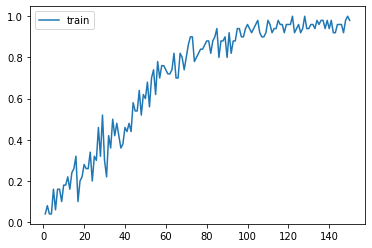

In [78]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [79]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [80]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "ALTASUR: " + random.choice(i["responses"])
            break
    return result

In [81]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

Buenas
ALTASUR: Hola!
Que corchos tienen
ALTASUR: Tenemos 8 tipos distintos de corchos, puedes ver las especificaciones en https://grupoaltasur.com/productos-y-servicios/
Podrias indicarme los precios
ALTASUR: Para brindarte precios deberías consultarnos al +549261672577
Envian a bodega?
ALTASUR: Puedes encontrarnos en <dirección>
Llevan  la bodega
ALTASUR: Visita nuestra web https://grupoaltasur.com/ para conocer las oficinas más cercanas
Como entregan el pedido
ALTASUR: Todos los pedidos son entregado en las instalaciones que tú solicites
Me podes asesorar
ALTASUR: Por asesoramiento profesional por favor comunicarse por whatsapp al +549261672577
Donde estan
ALTASUR: Visita nuestra web https://grupoaltasur.com/ para conocer las oficinas más cercanas
muchisimas gracias
ALTASUR: De nada


KeyboardInterrupt: ignored

### 7 - Conclusiones
Inicialmente se probó con 2 capas densas y luego al agregar la tercera capa el número de epoch se redujo a 150 o incluso puede ser menor.
Se puede apreciar como no importan los signos de puntuación y/o mayúsculas